<a href="https://colab.research.google.com/github/christ002/FashMNIST/blob/master/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from itertools import chain 

In [0]:
BATCH_SIZE = 50
# With a batch size of 50, our total number of batches will be 1200.

#Defining the transforms
transform = transforms.Compose([transforms.ToTensor()])

# Download and load training and testing dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=10)

# Download and load testing dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=10)

In [0]:
# Creating a class for the hyper parameters will make life easier when tuning the model 
class HypParam:
    inputs = 64*5*5
    hidden_layer1 = 128
    hidden_layer2 = 64
    hidden_layer3 = 32
    outputs = 10
    learning_rate = 0.01
    num_epochs = 2

In [0]:
# Network architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(HypParam.inputs, HypParam.hidden_layer1)
        self.fc1 = nn.Linear(HypParam.hidden_layer1, HypParam.hidden_layer2)
        self.fc2 = nn.Linear(HypParam.hidden_layer2, HypParam.outputs)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
# If GPU is available, select GPU, if not then select CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
# Instantiating
Model_cnn = CNN()
Model_cnn.to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(Model_cnn.parameters(), lr=HypParam.learning_rate)

In [89]:
count = 0

loss_lst = []
iter_lst = []
acc_lst = []

pred_lst = []
labels_lst = []

for epoch in range(HypParam.num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(BATCH_SIZE, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = Model_cnn(train)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        # Propagate backwards
        loss.backward()
        
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not(count%100):    
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_lst.append(labels)
            
                test = Variable(images.view(BATCH_SIZE, 1, 28, 28))
            
                outputs = Model_cnn(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                pred_lst.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_lst.append(loss.data)
            iter_lst.append(count)
            acc_lst.append(accuracy)
        
        if not (count % 500):
            print('Iteration: %0.3f, Epoch: %d of %d, Loss: %0.3f, Test Acc: %d'
            % (count, epoch+1, HypParam.num_epochs, loss.data, accuracy))
            

Iteration: 500.000, Epoch: 1 of 2, Loss: 0.514, Test Acc: 84
Iteration: 1000.000, Epoch: 1 of 2, Loss: 0.291, Test Acc: 87
Iteration: 1500.000, Epoch: 2 of 2, Loss: 0.508, Test Acc: 88
Iteration: 2000.000, Epoch: 2 of 2, Loss: 0.220, Test Acc: 88


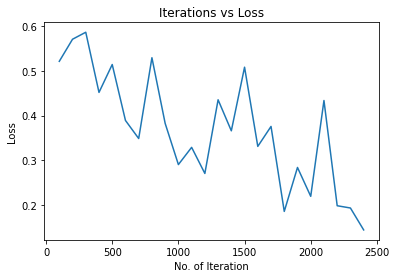

In [90]:
# Visualizing

plt.plot(iter_lst, loss_lst)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

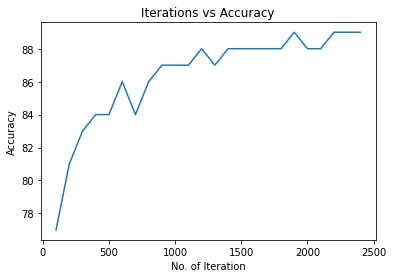

In [91]:
plt.plot(iter_lst, acc_lst)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [0]:
preds_l = [pred_lst[i].tolist() for i in range(len(pred_lst))]
labels_l = [labels_lst[i].tolist() for i in range(len(labels_lst))]
preds_l = list(chain.from_iterable(preds_l))
labels_l = list(chain.from_iterable(labels_l))

In [93]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, preds_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, preds_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     24000
           1       0.98      0.97      0.97     24000
           2       0.77      0.80      0.79     24000
           3       0.85      0.89      0.87     24000
           4       0.78      0.77      0.77     24000
           5       0.96      0.96      0.96     24000
           6       0.66      0.63      0.65     24000
           7       0.93      0.93      0.93     24000
           8       0.96      0.97      0.97     24000
           9       0.95      0.96      0.95     24000

    accuracy                           0.87    240000
   macro avg       0.87      0.87      0.87    240000
weighted avg       0.87      0.87      0.87    240000




In [0]:
torch.save(Model_cnn.state_dict(), 'checkpoint.pth')

In [95]:
Model_cnn.load_state_dict(torch.load('checkpoint.pth'))
Model_cnn.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1600, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=Tru